# Cross-correlation (8 marks, 4/4)

It has been shown that noise records at two seismic stations, when cross-correlated and stacked,
are very closely associated with the Green's function between these two seismic stations (i.e. given
a delta force at one station, the displacement recorded at the other station). On Quercus,
two files are given: one is a vertical component seismogram at PHL (Park Hill) and the other is
a vertical component seismogram at MLAC (Mammoth Lakes). Both are records for one day (24
hours) on February 1, 2003. Sampling rate is $dt = 1.0$ seconds.

 1. Take the cross-correlation (using FFT) of these seismograms using the record at PHL as $x(t)$
    and that at MLAC as $y(t)$ and plot $C_{xy}(\tau)$. Zoom in your plot between [-300; 300] seconds.
 2. Bit conversion is often used for the cross-correlation Greens function approach. It simply
    changes any positive numbers to 1 and negative numbers to -1 (numpy `sign()` function).
    Apply this to the data at PHL and MLAC and compute their cross-correlation. Compare
    the results against those from the previous step. Does bit-conversion work in this case to
    preserve the phase information of the true cross-correlation? (Note the amplitude of
    bit-converted cross-correlation is of no meaning).

    _Hint_: for discrete cross-correlation using fft:
    - suppose `x = [x0 x1 ... x(N-1)]; y = [y0 y1 ... y(N-1)]`
    - note conv(x,y)=v=[v0 v1 ... v(2N-2)], and notice the relationship between convolution and cross-correlation
    - also note how the fourier transform of the cross-correlation is related to $X(w)^*Y(w)$
    - if we first pad the end of each x and y array with N-1 zeros, convolution theorem suggests that we can interpret the inverse transform of $X^*(w)Y(w)$ as the result of a convolution (length 2N-1), w, interpreted as:  
          w = ifft(...)
            = [w[lag = 0] w[lag = 1 dt] ... w[lag = (N-1) dt] w[lag = -(N-1) dt] ... w[lag = -1 dt]]
    - we then must apply fftshift to center the time shift/lag axis at 0
    - the point of this fft approach is that it's much faster than directly convolving; you can check against  np.correlate(x, y, mode='same')
    - "zoom your plot to [-300, 300]" is in reference to the time lag axis in the above process

    _Hint_: you can load the ascii file into Python by `genfromtxt` function:  
        tmp = np.genfromtxt('MLAC_data.txt')  
        mlac = tmp.flatten()

__Q1__

Below we take the cross-correlation between the two data sets.

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [578]:
# import data

phl_values = np.loadtxt('PHL_data.txt')
mlac_values = np.loadtxt('MLAC_data.txt')
phl = phl_values.flatten()
mlac = mlac_values.flatten()

In [579]:
dt = 1 # sec

# FFT both functions
phl_fft = np.fft.fft(phl) * dt
mlac_fft = np.fft.fft(mlac) * dt

comb_fft = np.conjugate(phl_fft) * mlac_fft

comb = np.fft.fftshift(np.fft.ifft(comb_fft) / dt)
tau = len(comb)/2
t = np.arange(-tau, tau, 1)

(-300.0, 300.0)

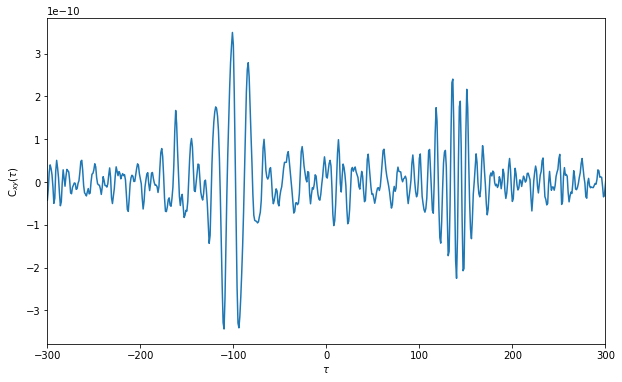

In [580]:
plt.figure(figsize=(10,6))
plt.plot(t, np.real(comb))
plt.xlabel("$\\tau$")
plt.ylabel("C$_{xy}$($\\tau$)")
plt.xlim(-300, 300)

__Q2__

Below we compute the bit conversion of our data.

In [581]:
phl_flip = np.sign(phl)
mlac_flip = np.sign(mlac)

(-300.0, 300.0)

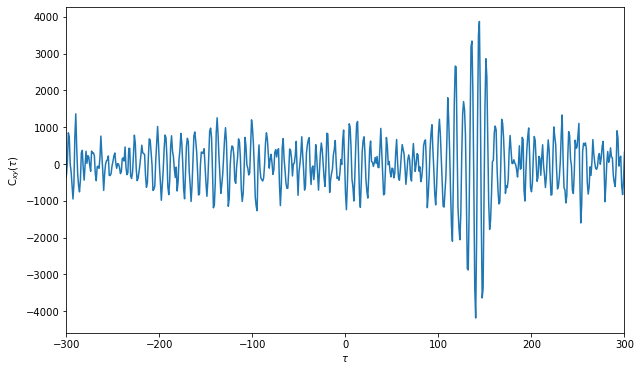

In [582]:
# FFT both functions
phl_fft = np.fft.fft(phl_flip) * dt
mlac_fft = np.fft.fft(mlac_flip) * dt

comb_fft = np.conjugate(phl_fft) * mlac_fft

new_comb = np.fft.fftshift(np.fft.ifft(comb_fft) / dt)
tau = len(comb)/2
t = np.arange(-tau, tau, 1)

plt.figure(figsize=(10,6))
plt.plot(t, np.real(new_comb))
plt.xlabel("$\\tau$")
plt.ylabel("C$_{xy}$($\\tau$)")
plt.xlim(-300, 300)

Below we try to plot both with and without the bit conversion while not minding the amplitude. We can see that their relative amplitudes are not the same at their relative phases. This means that bit conversion does not preserve the phase information. 

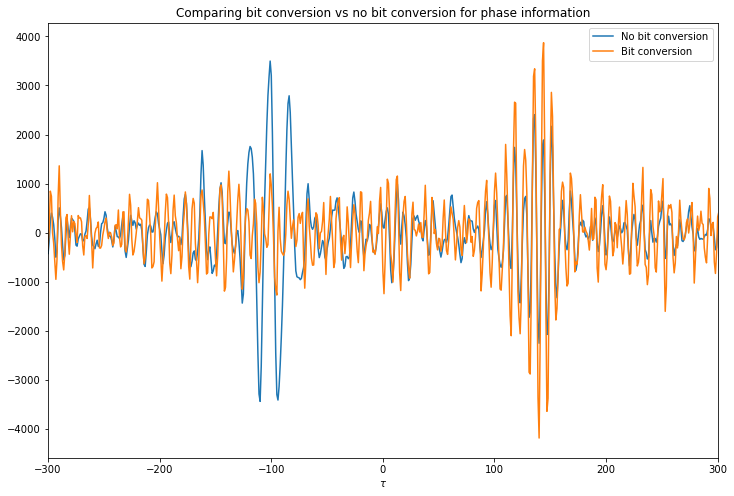

In [591]:
plt.figure(figsize=(12,8))
plt.plot(t, np.real(comb*1e13), label="No bit conversion")
plt.plot(t, np.real(new_comb), label="Bit conversion")
plt.title("Comparing bit conversion vs no bit conversion for phase information")
plt.xlabel("$\\tau$")
plt.xlim(-300, 300)
plt.legend()

# Normal Modes from Long Period Seismometer (7 marks, 1/2/2/1/1)

Background: The solid earth 'rings' like a bell after being struck by a great earthquake. These
are the normal modes associated with internal structures (density and elastic moduli) of the Earth,
and the excitation amplitudes of these modes are determined by the earthquake source mechanism.
The frequencies of these normal modes of oscillation are very low, usually between 0.1 milliHertz
(mHz) and 10 mHz. It is hard to see them above 10 mHz because these higher frequency modes
attenuate quickly, or the frequency spacings are too small to be identified individually. Because
the Earth is a complex structure, with twisting, breathing, and more complex spatial structure in
its modes, the modal frequencies are not simple multiples of a single fundamental as is the case
for a guitar string. They are labelled with a notation (e.g. like $_0S_2$ for spheroidal modes or like
$_1T_8$ for toroidal modes) based on the spherical harmonic spatial distribution that the mode corresponds
to, in the same way that the electron wavefunctions for the Hydrogen atom are labelled. Geophysicists
measure these frequencies because they can be used to invert for models of the Earth's
internal seismic velocity and density structures. With very high-resolution data, one can even see
splitting of these resonances due to the Earth’s rotation and elliptical shape, in a matter analogous
to the Zeeman splitting of atomic spectral lines. You can also optically detect similar phenomenon
('helioseismology') going on in the sun, from which one can also test models of the sun's interior.
(More descriptions can be found on any introductory solid-earth geophysics book).
Here we examine three days of very long period seismic data recorded on the horizontal direction at
station NWAO (Narrogin, Western Australia) after the devastating $M_w = 9.0$, Mar 11th, 2011 Honshu,
Japan earthquake. Data `nwao.vh1` (VH channel, $dt = 10 \text{ sec}$) is given as an ascii
file with two columns: time and velocity (in counts from the digitizer).

 1. Plot the raw data with a time axis in hours.
 2. Plot the power spectrum of your raw data as a function of frequency (in mHz) **without**
    any windowing.
 3. Plot the power spectrum of your raw data after 
     - removing the minor linear trend in the same way as Lab 3, and subsequently 
     - applying a hanning window $w_n = 1 - \cos(2 \pi \frac{n}{N}) ; 0 \leq n \leq N$ (where N is the length of the data file)
 4. Plot on top of each other the power spectra from 2 and 3 between [0.1, 2.6] mHz, and comment on the difference.
 5. Using plt.annotate(...), identify any normal modes you can see. Use the provided modes.pdf (Table 1) to help guide your identification.

In [496]:
nwao = np.loadtxt('nwao.vh1') # load data
time, velocity = nwao[:,0], nwao[:,1] # set data to variables time (s) and velocity (in counts)

__Q1__

Text(0, 0.5, 'Velocity (in counts)')

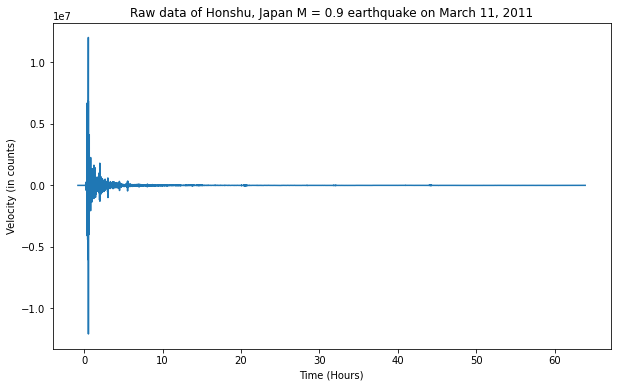

In [497]:
plt.figure(figsize=(10,6))
plt.plot(time*(1/60)*(1/60), velocity) # plotting in hours
plt.title("Raw data of Honshu, Japan M = 0.9 earthquake on March 11, 2011")
plt.xlabel("Time (Hours)")
plt.ylabel("Velocity (in counts)")

__Q2__

Power spectrum definition:

$$
P(f) = \frac{|FT|^2}{len(T)*dt}
$$

Text(0, 0.5, '$|P(f)|^2$')

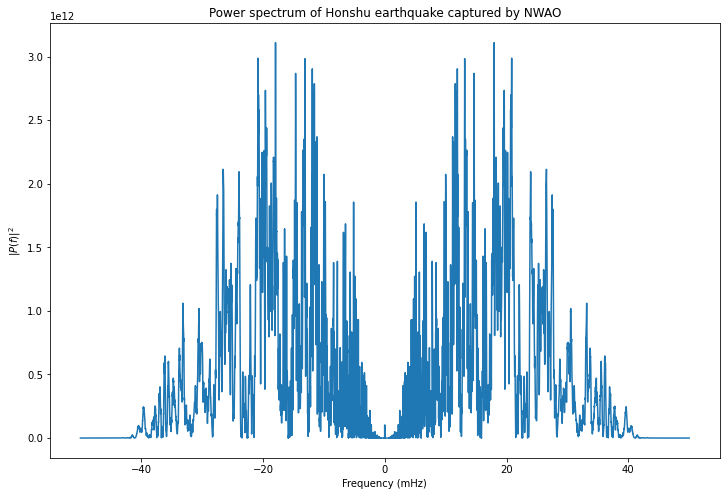

In [498]:
dt = time[1] - time[0]
f_velocity = np.fft.fftshift(np.fft.fft(velocity)*dt)
freq = np.fft.fftshift(np.fft.fftfreq(len(velocity), dt))
power_spec = (np.abs(f_velocity)**2) / (len(time)*dt)

plt.figure(figsize=(12,8))
plt.plot(freq*1e3, power_spec)
plt.title("Power spectrum of Honshu earthquake captured by NWAO")
plt.xlabel("Frequency (mHz)")
plt.ylabel("$|P(f)|^2$")

__Q3__

Text(0, 0.5, 'Velocity (in counts)')

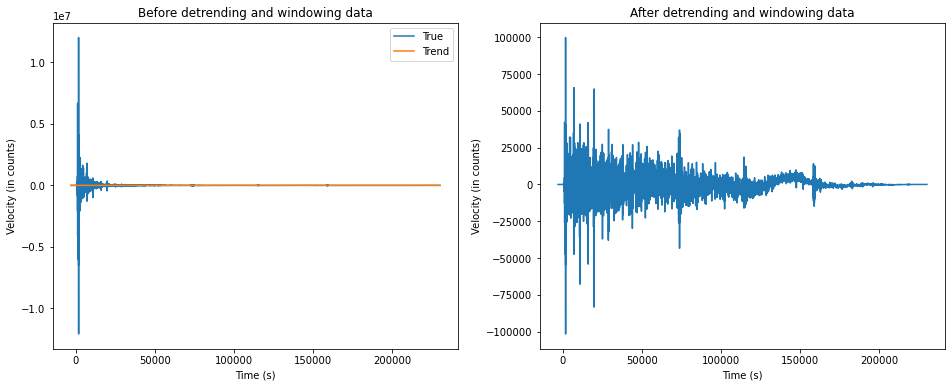

In [592]:
parameters = np.polyfit(time, velocity, 1)
linear_trend = parameters[0]*time + parameters[1]
window = 1 - np.cos(2*np.pi*np.arange(0, len(time))/len(time))
detrend_velocity = (velocity - linear_trend) * window # detrending and windowing

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(time, velocity, label="True")
ax[0].plot(time, linear_trend, label="Trend")
ax[0].set_title("Before detrending and windowing data")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Velocity (in counts)")
ax[0].legend()
ax[1].plot(time, detrend_velocity)
ax[1].set_title("After detrending and windowing data")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Velocity (in counts)")

Text(0, 0.5, '$|P(f)|^2$')

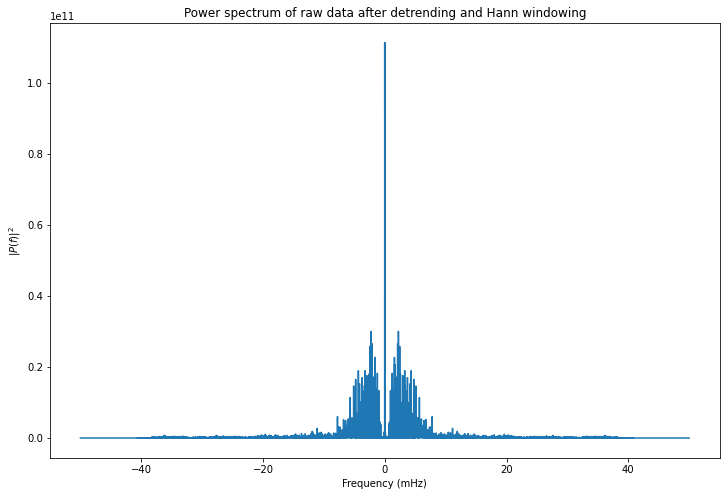

In [500]:
new_fvelocity = np.fft.fftshift(np.fft.fft(detrend_velocity)*dt)
new_pspec = (np.abs(new_fvelocity)**2) / (len(time)*dt)

plt.figure(figsize=(12,8))
plt.plot(freq*1e3, new_pspec)
plt.title("Power spectrum of raw data after detrending and Hann windowing")
plt.xlabel("Frequency (mHz)")
plt.ylabel("$|P(f)|^2$")

__Q4__

* Below we plot the new power spectrum from $f\in[0.1,2.6]$ and overlap the original one in the same range. 

We see that the data set that got detrended and windowed shows a watered down version of the original one in terms of its power. This is due to the process of cleaning out any noises in the data set that we are not interested in and only keeping the signals that truely give us what we are looking for. When we compare the cleaned data to the `modes.pdf` document, we see that we are able to identify the modes, some of which we have labeled in the next section. 

In [501]:
new_freq = (freq*1e3)[int(len(freq)/2):] # only positive freq
new_pspec = new_pspec[int(len(freq)/2):] # only positive freq spectrum
power_spec = power_spec[int(len(freq)/2):] # only positive freq spectrum
df = (freq*1e3)[1] - (freq*1e3)[0] # freq step size
start = int(0.1/df) # defining f = 0.1 mHz on x-axis
end = int(2.6/df) # defining f = 2.6 mHz on y-axis

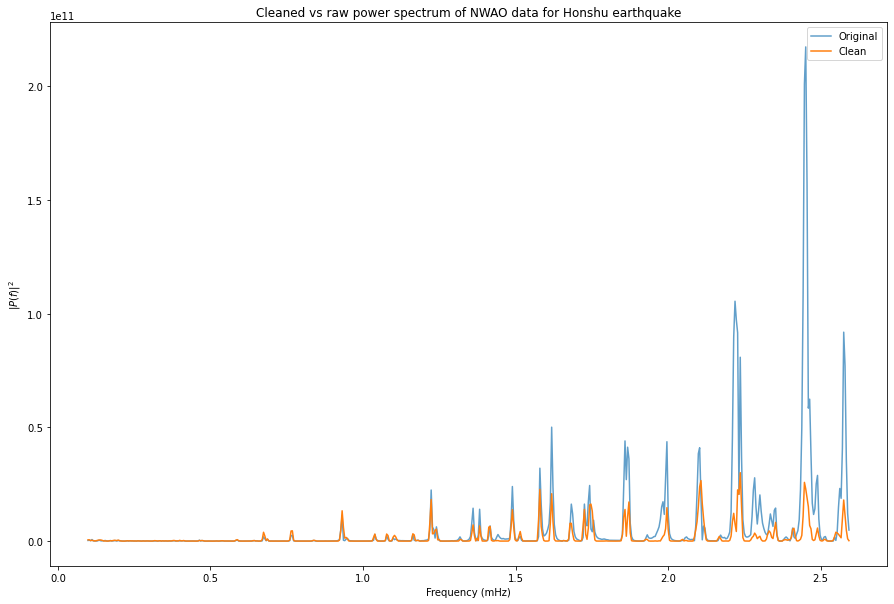

In [588]:
plt.figure(figsize=(15,10))
plt.plot(new_freq[start:end], power_spec[start:end], alpha=0.7, label="Original")
plt.plot(new_freq[start:end], new_pspec[start:end], label="Clean")
plt.title("Cleaned vs raw power spectrum of NWAO data for Honshu earthquake")
plt.xlabel("Frequency (mHz)")
plt.ylabel("$|P(f)|^2$")
plt.legend()

 __Q5__
 
* We also identify some of the modes by comparing the frequency values for peaks in the new spectrum to the frequencies in `mode.pdf`.

The modes that we have found are:  $_2 S_{11}$, $_0 S_{16}$, $_0 S_{14}$, $_0 T_{15}$, $_5 S_{3}$, $_0 S_{13}$, $_0 S_{12}$, $_0 T_{10}$

Text(1.2, 30000000000.0, '$_0 T_{10}, f = 1.614$')

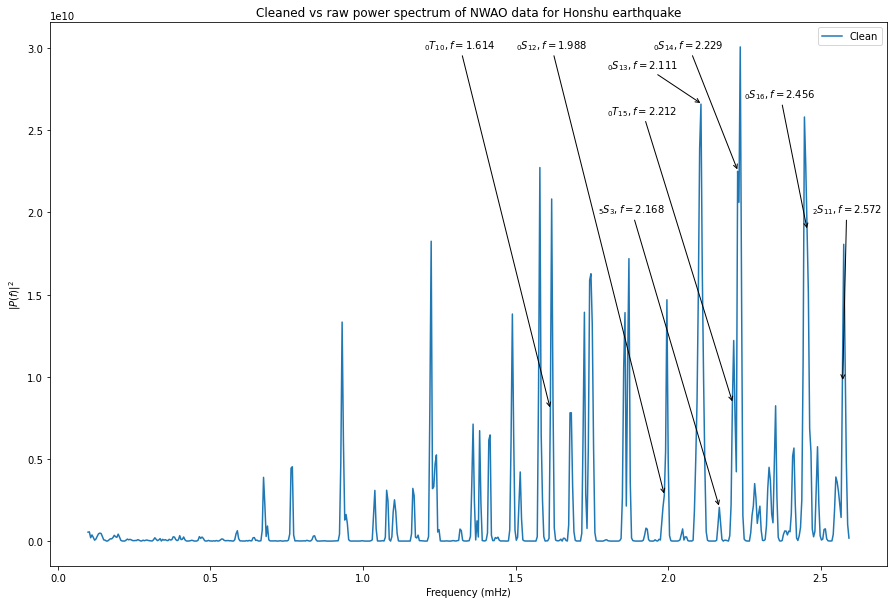

In [590]:
plt.figure(figsize=(15,10))
#plt.plot(new_freq[start:end], power_spec[start:end], alpha=0.7, label="Original")
plt.plot(new_freq[start:end], new_pspec[start:end], label="Clean")
plt.title("Cleaned vs raw power spectrum of NWAO data for Honshu earthquake")
plt.xlabel("Frequency (mHz)")
plt.ylabel("$|P(f)|^2$")
plt.legend()

plt.annotate("$_2 S_{11}, f = 2.572$", (2.572, new_pspec[int(2.572/df)]), xytext=(2.47, 2e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 S_{16}, f = 2.456$", (2.456, new_pspec[int(2.456/df)]), xytext=(2.25, 2.7e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 S_{14}, f = 2.229$", (2.229, new_pspec[int(2.229/df)]), xytext=(1.95, 3e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 T_{15}, f = 2.212$", (2.212, new_pspec[int(2.212/df)]), xytext=(1.8, 2.6e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_5 S_{3}, f = 2.168$", (2.168, new_pspec[int(2.168/df)]), xytext=(1.77, 2e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 S_{13}, f = 2.111$", (2.111, new_pspec[int(2.111/df)]), xytext=(1.8, 2.88e10), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 S_{12}, f = 1.988$", (1.988, new_pspec[int(1.988/df)]), xytext=(1.5, 0.3e11), arrowprops=dict(arrowstyle="->", facecolor='black'))
plt.annotate("$_0 T_{10}, f = 1.614$", (1.614, new_pspec[int(1.614/df)]), xytext=(1.2, 0.3e11), arrowprops=dict(arrowstyle="->", facecolor='black'))
